In [1]:
import tensorflow as tf
import rasterio
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

2024-11-22 11:08:39.389101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 11:08:39.408402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732241319.430832 3373129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732241319.437572 3373129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 11:08:39.460384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model = tf.keras.models.load_model("models/seg_v2_250_resnet50.h5", compile=False)

I0000 00:00:1732241324.129841 3373129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77212 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:18:00.0, compute capability: 9.0
I0000 00:00:1732241324.132102 3373129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 68713 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:2a:00.0, compute capability: 9.0
I0000 00:00:1732241324.134111 3373129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78260 MB memory:  -> device: 2, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:3a:00.0, compute capability: 9.0
I0000 00:00:1732241324.136126 3373129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78260 MB memory:  -> device: 3, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:5d:00.0, compute capability: 9.0
I0000 00:00:1732241324.138044 3373129 gpu_device.cc:2022] Create

In [3]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  8,617,408 │ input_layer_1[0]… │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 256), (None,  │            │                   │
│                     │ 16, 16, 512),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 512) │  4,719,104 │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 512) │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,544 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    590,080 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    131,200 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 19,445,569 (74.18 MB)

 Trainable params: 19,414,977 (74.06 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [24]:
with rasterio.open("dataset/test_images/test_8.tif") as src:
    image = src.read()
equalized_bands = []
for band in range(image.shape[2]):
    band_image = image[:,:,band]
    #min max scaller
    band_image = np.array((band_image - band_image.min()) / (band_image.max() - band_image.min()))
    band_image = np.nan_to_num(band_image, nan=0.0, posinf=255.0, neginf=0.0)
    band_image = (band_image * 255).astype(np.uint8)
    #his eq
    equalized_band = cv2.equalizeHist(band_image)
    equalized_bands.append(equalized_band)
image = np.stack(equalized_bands, axis=-1)
image = np.transpose(image, (1, 2, 0))

In [25]:
image.shape

(807, 803, 12)

In [ ]:
original_height = image.shape[0]  # Tinggi asli gambar
original_width = image.shape[1]   # Lebar asli gambar
patch_size = 128 # Ukuran patch yang digunakan

In [27]:
def create_patches(images, patch_size):
    patched_images = []
    for image in images:
        pad_height = (patch_size - image.shape[0] % patch_size) % patch_size
        pad_width = (patch_size - image.shape[1] % patch_size) % patch_size
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
        
        patches = patchify(padded_image, (patch_size, patch_size, 12), step=patch_size)
        patched_images.extend(patches.reshape(-1, patch_size, patch_size, 12))
    
    return np.array(patched_images)

In [28]:
from math import ceil

def reconstruct_image(patched_images, original_height, original_width, patch_size):
    padded_height = ceil(original_height / patch_size) * patch_size
    padded_width = ceil(original_width / patch_size) * patch_size
    
    reconstructed_image = np.zeros((padded_height, padded_width, patched_images.shape[-1]), dtype=patched_images.dtype)
    
    index = 0
    for i in range(0, padded_height, patch_size):
        for j in range(0, padded_width, patch_size):
            reconstructed_image[i:i + patch_size, j:j + patch_size, :] = patched_images[index]
            index += 1
    
    return reconstructed_image[:original_height, :original_width, :]

In [29]:
patch_image = create_patches([image], patch_size)
patch_image = patch_image/255
print(patch_image.shape, np.max(patch_image))

(49, 128, 128, 12) 1.0


In [30]:
patch_predict = model.predict(patch_image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 


(807, 803, 1)
[0. 1.]


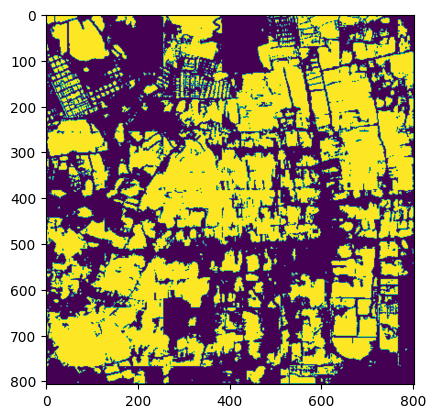

In [31]:
recons_mask = reconstruct_image(patch_predict, original_height, original_width, patch_size)
print(recons_mask.shape)
recons_mask = (recons_mask > .56).astype(np.float32)
print(np.unique(recons_mask))
plt.imshow(recons_mask)

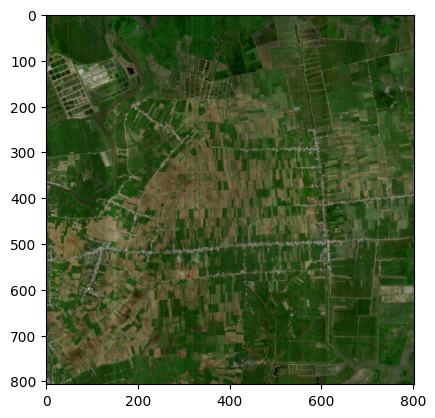

In [32]:
natural_image = np.stack((image[:, :, 3],image[:, :, 2],image[:, :, 1]))
natural_image = np.transpose(natural_image, (1, 2, 0))
plt.imshow(natural_image)

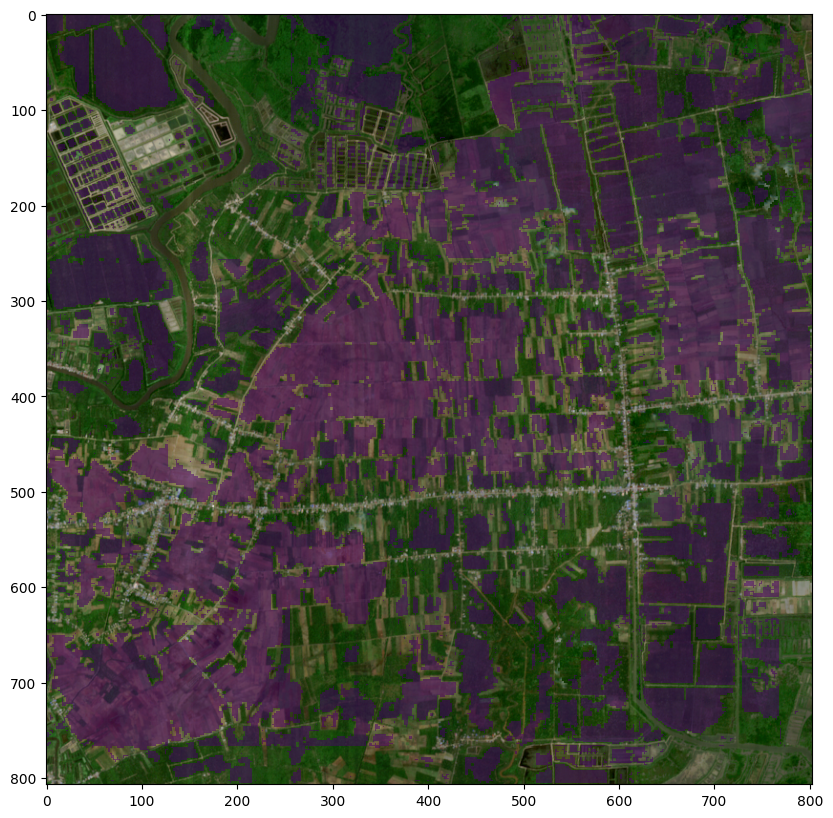

In [33]:
plt.figure(figsize=(30, 10))
plt.imshow(natural_image)
masked_mask = np.ma.masked_where(recons_mask < .5, recons_mask)
plt.imshow(masked_mask, alpha=.5, cmap="RdPu_r")